In [1]:
# i tutaj zaczyna się przygoda!

In [2]:
## Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import pandas as pd
import io
from scipy import stats
#import itertools
import datetime

In [3]:
# collecting data

infections = pd.read_csv('pre11_2020_infected_data.txt', sep = "\t", encoding = 'ANSI')
deaths = pd.read_csv('pre11_2020_deaths_data.txt', sep = "\t", encoding = 'ANSI')

infections2 = pd.read_csv('post11_2020_infected_data.txt', sep = "\t", encoding = 'ANSI')
deaths2 = pd.read_csv('post11_2020_deaths_data.txt', sep = "\t", encoding = 'ANSI')

population = pd.read_csv('new_ludnosc2.txt', sep = '\t', encoding = 'utf-8')

new_data = pd.read_csv('new_data.txt', sep = '\t', encoding = 'utf-8')

In [4]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [5]:
def print_how_many(x, rows):
    pd.set_option('display.max_rows', rows)
    print(x)
    pd.reset_option('display.max_rows')

In [6]:
# editing and sorting dataframes

def edit_pop(x):
    x = x.replace("\t", "")
    x = x.replace(" ", "")
    x = x.replace("Woj.", "")
    x = x.replace("M.", "")
    return x

def edit_inf(x):
    x = x.replace("Powiat ", "")
    x = x.replace(" ", "")
    x = x.replace("st.", "")
    x = x.replace("m.", "")
    return x

def edit_new(x):
    x = x.replace("\t", "")
    x = x.replace(" ", "")
    x = x.replace("st.", "")
    x = x.replace("M.", "")
    x = x.replace("Woj.", "")
    return x

population['new_district'] = population['district'].apply(edit_pop)
population['new_province'] = population['province'].apply(edit_pop)
population = population.drop(columns=['district'])
population = population.drop(columns=['province'])
population = population.rename(columns = {'new_district':'district'})
population = population.rename(columns = {'new_province':'province'})
population['district'] = population['district'].str.lower()
population['province'] = population['province'].str.lower()
#population = population.sort_values('district')

# tutaj edit nowych danych
new_data['new_district'] = new_data['district'].apply(edit_pop)
new_data['new_province'] = new_data['province'].apply(edit_pop)
new_data = new_data.drop(columns=['district'])
new_data = new_data.drop(columns=['province'])
new_data = new_data.rename(columns = {'new_district':'district'})
new_data = new_data.rename(columns = {'new_province':'province'})
new_data['district'] = new_data['district'].str.lower()
new_data['province'] = new_data['province'].str.lower()

infections['date'] = pd.to_datetime(infections['date'], format = '%d.%m.%Y') 
infections['district'] = infections['district'].apply(edit_inf)
infections['province'] = infections['province'].apply(edit_inf)
infections['district'] = infections['district'].str.lower()
infections['province'] = infections['province'].str.lower()
infections = infections.sort_values(by=['district', 'date'])

infections2['date'] = pd.to_datetime(infections2['date'], format = '%d.%m.%Y') 
infections2['district'] = infections2['district'].apply(edit_inf)
infections2['province'] = infections2['province'].apply(edit_inf)
infections2['district'] = infections2['district'].str.lower()
infections2['province'] = infections2['province'].str.lower()
infections2 = infections2[infections2.district != 'sumazpowiatów']
infections2 = infections2[infections2.district != infections2.province]
infections2 = infections2.sort_values(by=['district', 'date'])

deaths['date'] = pd.to_datetime(deaths['date'], format = '%d.%m.%Y') 
deaths['district'] = deaths['district'].apply(edit_inf)
deaths['province'] = deaths['province'].apply(edit_inf)
deaths['district'] = deaths['district'].str.lower()
deaths['province'] = deaths['province'].str.lower()
deaths = deaths.sort_values(by=['district', 'date'])

deaths2['date'] = pd.to_datetime(deaths2['date'], format = '%d.%m.%Y') 
deaths2['district'] = deaths2['district'].apply(edit_inf)
deaths2['province'] = deaths2['province'].apply(edit_inf)
deaths2['district'] = deaths2['district'].str.lower()
deaths2['province'] = deaths2['province'].str.lower()
deaths2 = deaths2[deaths2.district != 'sumazpowiatów']
deaths2 = deaths2[deaths2.district != deaths2.province]
deaths2 = deaths2.sort_values(by=['district', 'date'])

In [7]:
# which_district = "m.warszawa"
# fig, ax = plt.subplots()
# plt.plot_date(infections[infections.district == which_district]["date"], infections[infections.district == which_district]["infected_total"])
# plt.xlabel('Data')
# #plt.xticks([])
# plt.ylabel('Liczba zakażeń')
# every_nth = 3
# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     if n % every_nth != 0:
#         label.set_visible(False)
# plt.title("Warszawa")

In [8]:
# which_district = "m.warszawa"
# fig, ax = plt.subplots()
# plt.plot_date(deaths[deaths.district == which_district]["date"], deaths[deaths.district == which_district]["dead_total"])
# plt.xlabel('Data')
# plt.ylabel('Liczba śmierci')
# every_nth = 3
# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     if n % every_nth != 0:
#         label.set_visible(False)
# plt.title("Warszawa")

In [9]:
infections['population'] = 0
deaths['population'] = 0
infections2['population'] = 0
deaths2['population'] = 0

In [10]:
# dodawanie populacji do df: infections i deaths + przepisywanie ostatniej valid wartości + kolumna new_infeced, new_dead
last_infections = []
last_deaths = []

for ind in population.index:
    inf_cond = (infections['district'] == population['district'][ind]) & (infections['province'] == population['province'][ind])
    death_cond = (deaths['district'] == population['district'][ind]) & (deaths['province'] == population['province'][ind])
    infections.loc[inf_cond, 'population'] = population['population'][ind]
    deaths.loc[death_cond, 'population'] = population['population'][ind]
    
    inf_last_valid_idx = infections.loc[inf_cond].apply(pd.Series.last_valid_index)[3]
    death_last_valid_idx = deaths.loc[death_cond].apply(pd.Series.last_valid_index)[3]
    
    last_infections.append(infections.loc[inf_cond, 'infected_total'].loc[inf_last_valid_idx])
    last_deaths.append(deaths.loc[death_cond, 'dead_total'].loc[death_last_valid_idx])
    
    infections.loc[inf_cond, 'new_infected'] = infections.loc[inf_cond, 'infected_total'].diff()
    deaths.loc[death_cond, 'new_dead'] = deaths.loc[death_cond, 'dead_total'].diff()
    
    

In [11]:
# infections = infections.sort_values(by=['population', 'date'])
# print(infections)
#print(infections.loc[infections['district'] == "aleksandrowski"])

In [12]:
# tutaj probujemy zrobic cumsum poprawnie no i dodaje populację do dataframe'u jak wyżej

for ind in population.index:
    inf_cond = (infections2['district'] == population['district'][ind]) & (infections2['province'] == population['province'][ind])
    death_cond = (deaths2['district'] == population['district'][ind]) & (deaths2['province'] == population['province'][ind])
    
    infections2.loc[inf_cond, 'population'] = population['population'][ind]
    deaths2.loc[death_cond, 'population'] = population['population'][ind]
    
    infections2.loc[inf_cond, 'infected_total'] = infections2.loc[inf_cond, 'new_infected'].cumsum()
    deaths2.loc[death_cond, 'dead_total'] = deaths2.loc[death_cond, 'new_death'].cumsum()
    
    infections2.loc[inf_cond, 'infected_total'] = infections2.loc[inf_cond, 'infected_total'] + last_infections[ind]
    deaths2.loc[death_cond, 'dead_total'] = deaths2.loc[death_cond, 'dead_total'] + last_deaths[ind]


#print(infections2.loc[infections2['date'] == "2020-11-24"])

Text(0.5, 1.0, '01.09.2021r.')

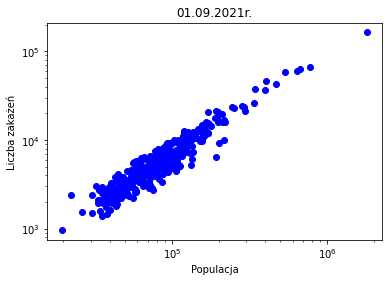

In [13]:
x = infections2.loc[infections2['date'] == '2021-09-01', 'population']
y = infections2.loc[infections2['date'] == '2021-09-01', 'infected_total']

plt.plot(x, y, 'bo')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Populacja')
plt.ylabel('Liczba zakażeń')
plt.title("01.09.2021r.")

In [14]:
#łączę dataframe'y
# infections = pd.concat([infections, infections2], verify_integrity=True)
# deaths = pd.concat([deaths, deaths2], verify_integrity=True)
# infections = pd.concat([infections, infections2], ignore_index=True)
# deaths = pd.concat([deaths, deaths2], ignore_index=True)
infections = pd.concat([infections, infections2])
infections = infections.sort_values(by=['district', 'date'])
infections = infections.reset_index(drop=True)

deaths = pd.concat([deaths, deaths2])
deaths = deaths.sort_values(by=['district', 'date'])
deaths = deaths.reset_index(drop=True)



In [15]:
# print(deaths)
# print_full(deaths.loc[deaths['district'] == "augustowski"])
# print(deaths.loc[deaths['district'] == "aleksandrowski"])
# print(infections.loc[infections['district'] == "dolnośląski"])

Text(0.5, 1.0, 'Warszawa')

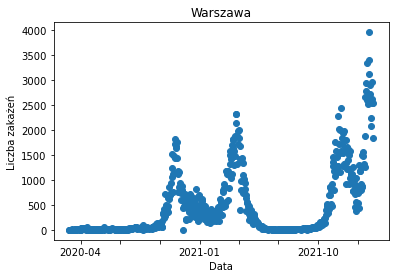

In [39]:
which_district = "warszawa"
fig, ax = plt.subplots()
plt.plot_date(infections[infections.district == which_district]["date"], infections[infections.district == which_district]["new_infected"])
plt.xlabel('Data')
#plt.xticks([])
plt.ylabel('Liczba zakażeń')
every_nth = 3
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.title("Warszawa")

In [17]:
# tworzenie listy nr. indeksów dla pierwszego dnia pandemii dla danego powiatu dla zakażeń
infections['pandemic_day'] = 0
min_value_inf = 10  # dokładnie to liczymy od kiedy ta wartość zostanie przekroczona
first_day_inf = [] 
t = []
for ind in population.index:
    bool_infected = []
    cond = (infections['district'] == population['district'][ind]) & (infections['province'] == population['province'][ind])
    one_district = infections.loc[cond]
    if not one_district.empty:
        #print(population['district'][ind])
        t.append(population['district'][ind])
        one_district = one_district.sort_values(by=['date'])
        #one_district = one_district.reset_index(drop=True)
        #print_full(one_district.loc[one_district['infected_total'] > min_value_inf])
        condition = one_district['infected_total'] > min_value_inf
        indices = one_district.index[condition]
        indices_list = indices.tolist()
        #print(indices_list)
        if indices_list:
            first_day_inf.append(indices_list[0])
        else:
            indices_list[0] = one_district.index.to_list()[-1]
            first_day_inf.append(indices_list[0])
        
        infections.loc[cond, 'pandemic_day'] = infections.index[cond] - indices_list[0]
        
#         dates = one_district.loc[condition, 'date']
#         dates_list = dates.tolist()
#         #print(dates_list)
#         if dates_list:
#             first_day_inf.append(dates_list[0])
#         else:
#             dates_list[0] = one_district.loc[condition, 'date'].to_list()[-1]
#             first_day_inf.append(dates_list[0])
            
#         infections.loc[cond, 'pandemic_day'] = (infections.loc[cond, 'date'] - dates_list[0]).days
#         #print(dates)

# pomysł - co jakby w dobrym momencie przesortować, to nie pomoże?

#print(first_day_inf)
#print(len(first_day_inf))


In [18]:
# print_full(infections.loc[infections['district'] == 'aleksandrowski'])

In [19]:
# tworzenie listy nr. indeksów dla pierwszego dnia pandemii dla danego powiatu dla zgonów
deaths['pandemic_day'] = 0
min_value_deaths = 3 # dokładnie to liczymy od kiedy ta wartość zostanie przekroczona
first_day_deaths = []
t = []
for ind in population.index:
    bool_dead = []
    cond = (deaths['district'] == population['district'][ind]) & (deaths['province'] == population['province'][ind])
    one_district = deaths.loc[cond]
    if not one_district.empty:
        #print(population['district'][ind])
        t.append(population['district'][ind])
        one_district = one_district.sort_values(by=['date'])
        #one_district = one_district.reset_index(drop=True)
        #print_full(one_district.loc[one_district['dead_total'] > min_value_deaths])
        condition = one_district['dead_total'] > min_value_deaths
        indices = one_district.index[condition]
        indices_list = indices.tolist()
        #print(indices_list)
        if indices_list:
            first_index = indices_list[0]
            first_day_deaths.append(first_index)
        else:
            first_index = one_district.index.to_list()[-1]
            first_day_deaths.append(first_index)

        deaths.loc[cond, 'pandemic_day'] = deaths.index[cond] - first_index

#print(first_day_deaths)
#print(len(first_day_deaths))


In [20]:
def fit_loglog(x, y):

    idx = np.isnan(y)
    xlog = np.log10(x)
    ylog = np.log10(y)

    a, b = np.polyfit(xlog[~idx],ylog[~idx],1)
    return a

In [21]:
def fit_loglog_scipy(x, y):

    idx = np.isnan(y)
    xlog = np.log10(x)
    ylog = np.log10(y)

    slope, intercept, r_value, p_value, std_err = stats.linregress(xlog[~idx],ylog[~idx])
    
    return slope, intercept, r_value, p_value

In [22]:
# dopasowanko prostej w skali log-log i wyplotowanie

def fit_n_plot_loglog(x, y, title, yscale_label):

    plt.plot(x, y, 'bo')
    plt.title(title)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel('Populacja')
    plt.ylabel(yscale_label)

    idx = np.isnan(y)
    xlog = np.log10(x)
    ylog = np.log10(y)
    
    a, b = np.polyfit(xlog[~idx],ylog[~idx],1)
    plt.plot(x, pow(x, a) * pow(10, b), color='red')
    return a, b

In [23]:
# dopasowanko prostej w skali log-log i wyplotowanie

def fit_n_plot_loglog_scipy(x, y, title, yscale_label):

    plt.plot(x, y, 'bo')
    plt.title(title)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel('Populacja')
    plt.ylabel(yscale_label)

    idx = np.isnan(y)
    xlog = np.log10(x)
    ylog = np.log10(y)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(xlog[~idx],ylog[~idx])
    plt.plot(x, pow(x, slope) * pow(10, intercept), color='red')
    return slope, intercept, r_value, p_value, std_err

Text(0.5, 1.0, '01.09.2020r.')

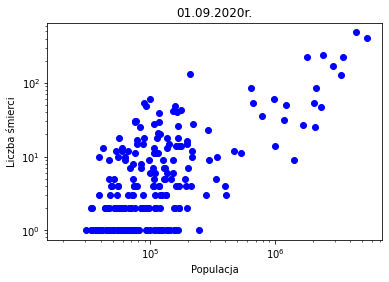

In [24]:
x = deaths.loc[deaths['date'] == '2020-09-01', 'population']
y = deaths.loc[deaths['date'] == '2020-09-01', 'dead_total']

plt.plot(x, y, 'bo')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Populacja')
plt.ylabel('Liczba śmierci')
plt.title("01.09.2020r.")

Text(0.5, 1.0, '01.09.2020r.')

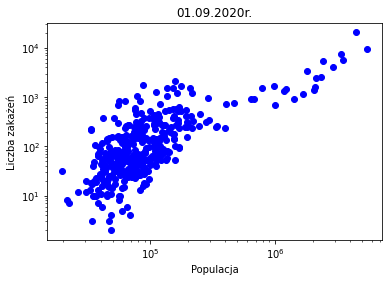

In [25]:
x = infections.loc[infections['date'] == '2020-09-01', 'population']
y = infections.loc[infections['date'] == '2020-09-01', 'infected_total']

plt.plot(x, y, 'bo')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Populacja')
plt.ylabel('Liczba zakażeń')
plt.title("01.09.2020r.")

Text(0, 0.5, 'Liczba zgonów')

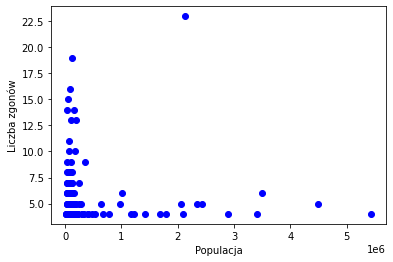

In [26]:
# Ile śmierci w pierwszy dzień pandemii
x = deaths.loc[deaths['pandemic_day'] == 0, 'population']
y = deaths.loc[deaths['pandemic_day'] == 0, 'dead_total']

plt.plot(x, y, 'bo')
plt.xlabel('Populacja')
plt.ylabel('Liczba zgonów')

#tutaj widać, że przez wybrakowane dane na początku, niektóre powiaty w pierwszy dzień mają dużo zakażonych 
#(zweryfikowałem, tak jest w danych)

In [27]:
#print_full(infections.loc[infections['district'] == "dolnośląskie"])
#print_full(infections.loc[infections['pandemic_day'] == 0])
#print_full(infections.loc[infections['district'] == "augustowski"])
#print_full(infections.loc[infections['district'] == "dolnośląskie"])

Text(0, 0.5, 'Liczba zakażeń')

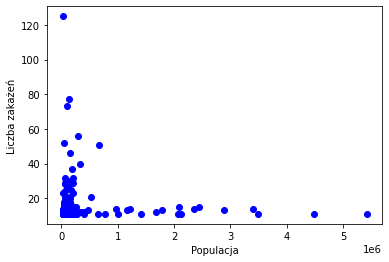

In [28]:
# Ile zakażonych w pierwszy dzień pandemii
x = infections.loc[infections['pandemic_day'] == 0, 'population']
y = infections.loc[infections['pandemic_day'] == 0, 'infected_total']

plt.plot(x, y, 'bo')
plt.xlabel('Populacja')
plt.ylabel('Liczba zakażeń')

#tutaj widać, że przez wybrakowane dane na początku, niektóre powiaty w pierwszy dzień mają dużo zakażonych 
#(zweryfikowałem, tak jest w danych)

a = 0.381030099714657
b = 0.11618909694455803
R^2 = 0.1845018555570254
p = 3.1846388850849862e-18


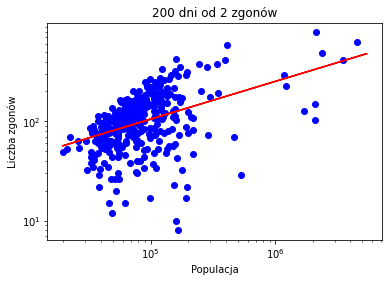

In [29]:
#264 dni z danych
# do prezentacji 
x = deaths.loc[deaths['pandemic_day'] == 200, 'population']
y = deaths.loc[deaths['pandemic_day'] == 200, 'dead_total']

a, b, r, p, std_err = fit_n_plot_loglog_scipy(x, y, "200 dni od 2 zgonów", "Liczba zgonów")
print("a = "+str(a))
print("b = "+str(b))
print("R^2 = "+str(r*r))
print("p = "+str(p))

a = 0.35924216988988544
b = 1.2577343662338307
R^2 = 0.08396923236206788
p = 6.074222587007809e-09


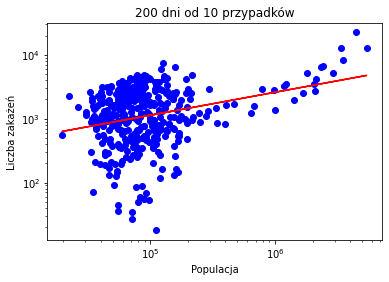

In [30]:
#264 dni z danych
# do prezentacji 
x = infections.loc[infections['pandemic_day'] == 200, 'population']
y = infections.loc[infections['pandemic_day'] == 200, 'infected_total']

#fit_n_plot_loglog(x, y, "200 dni od 10 przypadków", "Liczba zakażeń")
a, b, r, p, std_err = fit_n_plot_loglog_scipy(x, y, "200 dni od 10 przypadków", "Liczba zakażeń")
print("a = "+str(a))
print("b = "+str(b))
print("R^2 = "+str(r*r))
print("p = "+str(p))

In [31]:
#print_full(infections.loc[infections['district'] == "aleksandrowski"])

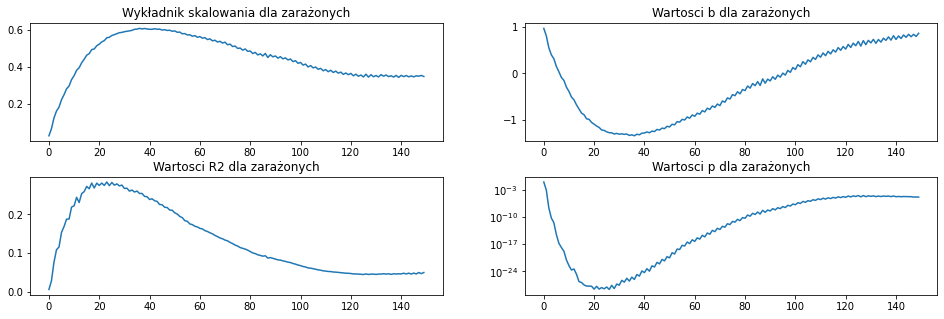

In [32]:
#
days_num = 150
wykladniki = []
wartosci_R2 = []
wartosci_p = []
wartosci_b = []
for i in range(days_num):
    x = infections.loc[infections['pandemic_day'] == i, 'population']
    y = infections.loc[infections['pandemic_day'] == i, 'infected_total']
    #a = fit_loglog(x, y)
    a, b, r, p = fit_loglog_scipy(x, y)
    wykladniki.append(a)
    wartosci_b.append(b)
    wartosci_R2.append(r*r)
    wartosci_p.append(p)

#print(len(wykladniki)) 

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 5))
fig.subplots_adjust(left=0.2, hspace = 0.3)
ax[0,0].plot(range(days_num), wykladniki, label='a')
ax[0,0].title.set_text('Wykładnik skalowania dla zarażonych')
ax[0,1].plot(range(days_num), wartosci_b, label='b')
ax[0,1].title.set_text('Wartosci b dla zarażonych')
ax[1,0].plot(range(days_num), wartosci_R2, label='R2')
ax[1,0].title.set_text('Wartosci R2 dla zarażonych')

ax[1,1].plot(range(days_num), wartosci_p, label='p')
ax[1,1].title.set_text('Wartosci p dla zarażonych')
ax[1,1].set_yscale("log")

#print(wartosci_p)
#plt.scatter(range(days_num), wykladniki, s=20)
#plt.ylim(0, 1)
# plt.title("Wykładnik skalowania dla zarażonych")
# plt.xlabel('Dni od rozpoczęcia pandemii')
# plt.ylabel("Wykładnik skalowania")
#plt.scatter(range(days_num), wartosci_R2, s=20)
#plt.scatter(range(days_num), wartosci_p, s=20)

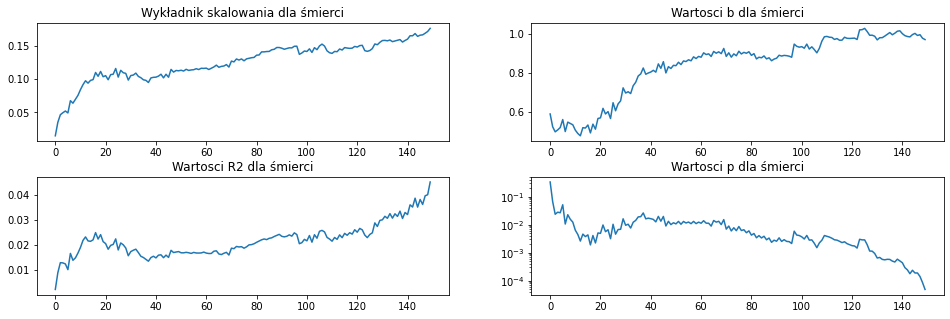

In [33]:
#
days_num = 150
wykladniki = []
wartosci_R2 = []
wartosci_p = []
wartosci_b = []
for i in range(days_num):
    x = deaths.loc[deaths['pandemic_day'] == i, 'population']
    y = deaths.loc[deaths['pandemic_day'] == i, 'dead_total']
    #a = fit_loglog(x, y)
    a, b, r, p = fit_loglog_scipy(x, y)
    wykladniki.append(a)
    wartosci_b.append(b)
    wartosci_R2.append(r*r)
    wartosci_p.append(p)
    
#print(len(wykladniki)) 

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 5))
fig.subplots_adjust(left=0.2, hspace = 0.3)
ax[0,0].plot(range(days_num), wykladniki, label='a')
ax[0,0].title.set_text('Wykładnik skalowania dla śmierci')
ax[0,1].plot(range(days_num), wartosci_b, label='b')
ax[0,1].title.set_text('Wartosci b dla śmierci')
ax[1,0].plot(range(days_num), wartosci_R2, label='R2')
ax[1,0].title.set_text('Wartosci R2 dla śmierci')

ax[1,1].plot(range(days_num), wartosci_p, label='p')
ax[1,1].title.set_text('Wartosci p dla śmierci')
ax[1,1].set_yscale("log")

# plt.scatter(range(days_num), wykladniki, s=20)
# plt.ylim(0, 1)
# plt.title("Wykładnik skalowania dla śmierci")
# plt.xlabel('Dni od rozpoczęcia pandemii')
# plt.ylabel("Wykładnik skalowania")



Text(0, 0.5, 'Liczba zgonów per capita')

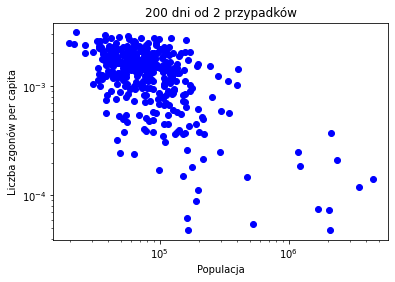

In [34]:
# do prezentacji 
x = deaths.loc[deaths['pandemic_day'] == 200, 'population']
y = deaths.loc[deaths['pandemic_day'] == 200, 'dead_total']

y = y / x
plt.plot(x, y, 'bo')
plt.title("200 dni od 2 przypadków")
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Populacja')
plt.ylabel('Liczba zgonów per capita')

Text(0, 0.5, 'Liczba zakażeń per capita')

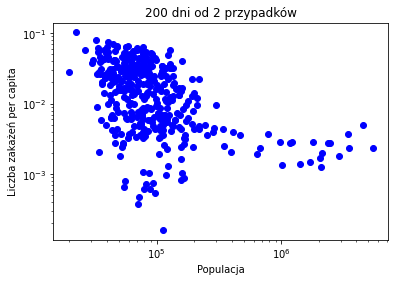

In [35]:
# do prezentacji 
x = infections.loc[infections['pandemic_day'] == 200, 'population']
y = infections.loc[infections['pandemic_day'] == 200, 'infected_total']

y = y / x
plt.plot(x, y, 'bo')
plt.title("200 dni od 2 przypadków")
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Populacja')
plt.ylabel('Liczba zakażeń per capita')

In [36]:
def compare(s, t):
    t = list(t)   # make a mutable copy
    try:
        for elem in s:
            t.remove(elem)
    except ValueError:
        return False
    return t

s = infections.loc[infections['date'] == '2020-08-25', 'district'].to_list()

print(compare(s, t))

#ok czyli jest git tutaj, wszystkie powiaty bierę pod uwagę

[]


In [37]:
#posumowac dane z powiatów do województw
# last_province_name = ""
# for ind in population.index:
#     suma = 0
#     one_province = infections.loc[(infections['province'] == population['province'][ind]) & (infections['date'] == '2020-08-25')]
#     if not one_province.empty:
#         if not (one_province['province'].iloc[0] == last_province_name):
#             last_province_name = one_province['province'].iloc[0]
#             #print(one_province)
#             suma += one_province['population'].sum()
#             whole_province = one_province.loc[one_province['province'] == one_province['district']]
#             suma /= 2
#             print(str(one_province['province'].iloc[0]))
#             print("Z danych: "+ str(whole_province['population'].iloc[0]))
#             print("Posumowane: " + str(suma))
#             print()
        

In [38]:
# Okej, obczaiłem. Jest rozbieżność pomiędzy danymi dot. zakażeń w tym pliku excelowskim, a tymi w tekstowym. 
# W tekstowym, skąd brałem dane nie ma wszystkich powiatów, np. w województwie kujawsko-pomorskim jest tylko powiat aleksanrowsk
# 